In [1]:
import sys
path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)
import ising

import os
os.chdir("/Users/mariusmahiout/Documents/repos/ising_core/python")
import src.misc_plotting as plotting
import src.utils as utils
import src.model_eval as eval
import src.isingfitter as fitter

import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [3]:
def get_pair_hamiltonian(s_i, s_j, J_ij, h_i, h_j):
    return -J_ij*s_i*s_j - h_i*s_i - h_j*s_j

def get_pair_partition_func(i, j, h, J):
    Z = (
        np.exp(-get_pair_hamiltonian(+1, +1, J[i,j], h[i], h[j]))
        + np.exp(-get_pair_hamiltonian(+1, -1, J[i,j], h[i], h[j]))
        + np.exp(-get_pair_hamiltonian(-1, +1, J[i,j], h[i], h[j]))
        + np.exp(-get_pair_hamiltonian(-1, -1, J[i,j], h[i], h[j]))
    )
    return Z

def get_m_pair(h, J, i, j):
    num = (
        np.exp(-get_pair_hamiltonian(+1, +1, J[i,j], h[i], h[j]))
        + np.exp(-get_pair_hamiltonian(+1, -1, J[i,j], h[i], h[j]))
        - np.exp(-get_pair_hamiltonian(-1, +1, J[i,j], h[i], h[j]))
        - np.exp(-get_pair_hamiltonian(-1, -1, J[i,j], h[i], h[j]))
    )
    m_ij = num / get_pair_partition_func(i, j, h, J)
    return m_ij

def get_chi_pair(h, J, i, j):
    num = (
        np.exp(-get_pair_hamiltonian(+1, +1, J[i,j], h[i], h[j]))
        - np.exp(-get_pair_hamiltonian(+1, -1, J[i,j], h[i], h[j]))
        - np.exp(-get_pair_hamiltonian(-1, +1, J[i,j], h[i], h[j]))
        + np.exp(-get_pair_hamiltonian(-1, -1, J[i,j], h[i], h[j]))
    )
    chi_ij = num / get_pair_partition_func(i, j, h, J)
    return chi_ij

def get_analytic_means(h: np.ndarray, J: np.ndarray, pairs: list) -> np.ndarray:
    num_units = h.shape[0]
    m = np.zeros(num_units)

    for (i, j) in pairs:
        m[i] = get_m_pair(h, J, i, j)
        m[j] = get_m_pair(h, J, j, i)

    return m

def get_analytic_pcorrs(h: np.ndarray, J: np.ndarray, pairs: list) -> np.ndarray:
    num_units = h.shape[0]
    chi = np.ones((num_units, num_units))

    m = get_analytic_means(h, J, pairs)
    for i in range(num_units):
        for j in [k for k in range(num_units) if k != i]:
             chi[i, j] = m[i] * m[j]
    
    for (i, j) in pairs:
        chi[i, j] = get_chi_pair(h, J, i, j)
        chi[j, i] = chi[i, j]
    
    return chi


In [40]:
num_units = 200
num_sims = 10_000
num_burn = 1000

In [41]:
##############
# SIMULATION #
##############

# setting up model
beta = 1.5
h = np.random.uniform(-5, 5, num_units)

J_IP = np.zeros((num_units, num_units))
if num_units % 2 == 0:
    pairs = np.split(np.random.permutation(num_units), num_units / 2)
else:
    pairs = np.split(np.random.permutation(num_units - 1), (num_units - 1) / 2)
for pair in pairs:
    J_IP[pair[0]][pair[1]] = np.random.normal(0, 1/np.sqrt(num_units))
    J_IP[pair[1]][pair[0]] = J_IP[pair[0]][pair[1]]

true_model = ising.EqModel(J_IP, h)

# simulating
true_sim = true_model.simulate(num_sims, num_burn)

In [42]:
chi_analytic = get_analytic_pcorrs(h, J_IP, pairs)
m_analytic = get_analytic_means(h, J_IP, pairs)

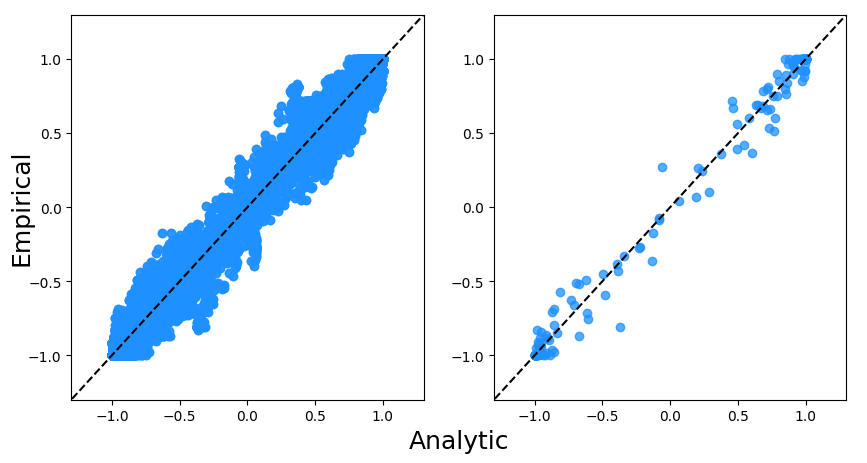

In [43]:
scatter_color = "dodgerblue"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0].scatter(chi_analytic, true_sim.getPairwiseCorrs(), color=scatter_color, alpha=0.75)

x = np.linspace(chi_analytic.min()-5, chi_analytic.max()+5, 10)
ax[0].plot(x, x, color="black", linestyle="--")

dx = .3
ax[0].set_xlim([chi_analytic.min()-dx, chi_analytic.max()+dx])
ax[0].set_ylim([chi_analytic.min()-dx, chi_analytic.max()+dx])

ax[1].scatter(m_analytic, true_sim.getMeans(), color=scatter_color, alpha=0.75)

x = np.linspace(m_analytic.min()-5, m_analytic.max()+5, 10)
ax[1].plot(x, x, color="black", linestyle="--")

dx = .3
ax[1].set_xlim([m_analytic.min()-dx, m_analytic.max()+dx])
ax[1].set_ylim([m_analytic.min()-dx, m_analytic.max()+dx])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Analytic", fontsize=18)
plt.ylabel("Empirical", fontsize=18)

plt.show()


### TO-DO: 
- confirm equation for chi_analytic, and derive equation for m_analytic
- make scatter plots
- plot sensitivity curves